In [1]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import re as re
import os
import copy
import statsmodels.formula.api as sm
import pymc3 as pm
import matplotlib.pyplot as plt
from tqdm import tqdm

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\Yurii\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
C:\Users\Yurii\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv im

In [2]:
drc = pd.read_excel('Data\\south_of_sahara\\DRC_Conflict_27June2012.xlsx', header = 0, index_col = 1)
uganda = pd.read_excel('Data\\south_of_sahara\\Uganda_Conflict_27June2012.xlsx', header = 0, index_col = 1)
ethiopia = pd.read_excel('Data\\south_of_sahara\\Ethiopia_Conflict_27June2012.xlsx', header = 0, index_col = 1)
sudan = pd.read_excel('Data\\south_of_sahara\\Sudan_Conflict_27June2012.xlsx', header = 0, index_col = 1)
burundi = pd.read_excel('Data\\south_of_sahara\\Burundi_Conflict_20June2012.xlsx', header = 0, index_col = 1)

ethiopia.drop(ethiopia[ethiopia['precision'] == '.'].index, inplace = True)
burundi.drop(burundi[burundi['precision'] == '        .'].index, inplace = True)

all_provinces = gpd.read_file('Data\\Shapefiles\\ADM1\\compiled.shp')

drc = drc[drc['precision'] <=6]
uganda = uganda[uganda['precision'] <=6]
ethiopia = ethiopia[ethiopia['precision'] <=6]
sudan = sudan[sudan['precision'] <=6]
burundi = burundi[burundi['precision'] <=6]

worker_deaths = pd.read_csv('Data\\security_incidents2018-08-02.csv', encoding = "ISO-8859-1")
conflict = pd.read_csv('Data\\conflict_data\\gedevents-2018-07-13.csv', header = 0, index_col = 0)

geometry = [Point(xy) for xy in zip(conflict.longitude, conflict.latitude)]
gconflict = gpd.GeoDataFrame(conflict, crs = {'init': 'epsg:4326'}, geometry = geometry)

geometry = [Point(xy) for xy in zip(worker_deaths.Longitude, worker_deaths.Latitude)]
g_w_d = gpd.GeoDataFrame(worker_deaths, crs = {'init': 'epsg:4326'}, geometry = geometry)

gconflict = gpd.sjoin(gconflict, all_provinces, how="inner")
g_w_d = gpd.sjoin(g_w_d, all_provinces, how="inner")

In [3]:
def recode_commitments(df):
    """
        Commitments are coded for for all locations within a project. 
        To arrive at an average per location divide the value over numbloc
    """
    df['usdcr'] = df['usdcr'] / df['numbloc']
    df['usdco'] = df['usdco'] / df['numbloc']
    return df

def geocode(df):
    geometry = [Point(xy) for xy in zip(df.long, df.lat)]
    gdf = gpd.GeoDataFrame(df, crs = {'init': 'epsg:4326'}, geometry = geometry)
    gaid = gpd.sjoin(gdf, all_provinces, how="inner")
    return gaid

In [4]:
countries = [drc, uganda, ethiopia, sudan, burundi]
geoaid = [geocode(country) for country in countries]
geoaid = list(map(recode_commitments, geoaid))

geoaid_df = pd.DataFrame()
for country in geoaid:
    geoaid_df = geoaid_df.append(country)

In [5]:
geoaid_df.loc[:, 'dname'] = geoaid_df['dname'].apply(lambda x: x.replace(" ", ""))
geoaid_df.loc[geoaid_df['dname'] == 'BELGIU', 'dname'] = 'BELGIUM'
geoaid_df.loc[geoaid_df['dname'] == 'FINLAN', 'dname'] = 'FINLAND'
geoaid_df.loc[geoaid_df['dname'] == 'IRELAN', 'dname'] = 'IRELAND'
geoaid_df.loc[geoaid_df['dname'] == 'PORTUG', 'dname'] = 'PORTUGAL'
geoaid_df.loc[geoaid_df['dname'] == 'GERMAN', 'dname'] = 'GERMANY'
geoaid_df.loc[geoaid_df['dname'] == 'AUSTRI', 'dname'] = 'AUSTRIA'
geoaid_df.loc[geoaid_df['dname'] == 'DENMAR', 'dname'] = 'DENMARK'
geoaid_df.loc[geoaid_df['dname'] == 'SWITZE', 'dname'] = 'SWITZERLAND'
geoaid_df.loc[geoaid_df['dname'] == 'LUXEMB', 'dname'] = 'LUXEMBOURG'
geoaid_df.loc[geoaid_df['dname'] == 'AUSTRA', 'dname'] = 'AUSTRALIA'
geoaid_df.loc[geoaid_df['dname'] == 'NETHER', 'dname'] = 'NETHERLANDS'

In [6]:
geoaid_df['crspcode'] =  geoaid_df['crspcode'].astype(str)
geoaid_df = geoaid_df.dropna(subset = ['usdco', 'crspcode'])
geoaid_df = geoaid_df[~geoaid_df.index.duplicated(keep='first')]

geoaid_df['fungible'] = 0
geoaid_df['nonfungible'] = 0

In [7]:
for i in geoaid_df.index:
    try:
        if geoaid_df.loc[i, 'crspcode'][:3] in ['311', '110', '230', '510']:
            geoaid_df.at[i, 'fungible'] = geoaid_df.loc[i, 'usdco']
        else:
            geoaid_df.at[i, 'nonfungible'] = geoaid_df.loc[i, 'usdco']
    except:
        print(i)

In [8]:
# Func calculates the coefficient of unalikeability (as defined by Kader 2007) of every sublcass of first_group variable by topic_name
# E.g. unalikeability of project location for each aid donor -> calc_unalikeability(gaid, 'donors', 'ad_sector_names')

def calc_unalikeability(data, first_group, topic_name):
    
    # prepare data: group by first_group and topic_name, and divide by the size of the respective group
    # thus we obtain the share that each topic_name has in the respective first_group
    
    d = (data.groupby([first_group, topic_name]).size() / data.groupby([first_group]).size())
    
    # here we get the keys for the first level grouping. So, the unique values of first group column
    keys = []
    for i in d.index:
        keys.append(i[0])
    keys = set(keys)
    
    # here we calculate the actual coefficient
    # for every value of first_group we calculate its coefficient:
    # coefficient is defined as 1 - SUM_i(p_i^2), where p_i is the share of the ith subgroup in the total group. 
    
    coefs = {}
    for key in keys:
        s = 0
        for subgroup in d[key]:
            s += subgroup ** 2
        coef = 1 - s
        coefs[key] = coef
    return pd.Series(coefs)


# calculates the variablity of topic_name (e.g. total commitments of money) for every member of first_group
def calc_var(data, first_group, topic_name):
    d = data.groupby(first_group)
    
    def var(d):
        d = d[topic_name]
        d = (d - min(d)) / (max(d) - min(d))
        
        if np.isnan(np.var(d)):
            return 0
        
        return np.var(d)
    
    return d.apply(var)

In [9]:
adaptability_by_focus = calc_unalikeability(geoaid_df, 'dname', 'crspcode')
adaptability_by_location =calc_unalikeability(geoaid_df, 'dname', 'NAME_1')
adaptability_by_start_year = calc_unalikeability(geoaid_df, 'dname', 'year')
adaptability_by_commitment = calc_var(geoaid_df, 'dname', 'usdco')
composite_adaptability = adaptability_by_commitment + adaptability_by_start_year + adaptability_by_location + adaptability_by_focus
median = composite_adaptability.median()
high_adaptability = composite_adaptability[composite_adaptability >= median]
low_adaptability = composite_adaptability[composite_adaptability < median]

In [10]:
# Compute the year, ADM1 pairs of events when aid workers were killed. 
# Then, we can assume that these are unreceptive year, region pairs.
# However, we can also divide this into 2 subgroups: more than average (or median) casualties vs less than average (or median) casualties
worker_deaths_grouped = g_w_d.groupby(['Year', 'NAME_1'])['Total affected'].sum()
worker_deaths_grouped.to_csv('measures_indices\\year_location_pairs.csv')

# The idea is that low_receptivity is depcited by a lot of worker deaths
# high receptivity is depicted by a no worker deaths


In [11]:
# custom function to check whether a tuple is included in an array of tuples (for some reason, basic function did not work)
def check_in (tupl, array):
    for element in array:
        if (tupl[0] == element[0]) & (tupl[1] == element[1]):
            return True

# select those row numbers (indices) of gaid dataframe that represent projects that started in the same year/adm1 combination
# as highly receptive ones
low_receptive_indices = []

low_receptive = pd.DataFrame()
highly_receptive = pd.DataFrame()


for index, row in tqdm(geoaid_df.iterrows()):
    tupl = (int(row['year']), row['NAME_1'])
    if check_in(tupl, worker_deaths_grouped.index.values):
        low_receptive_indices.append(index)
        low_receptive = low_receptive.append(row)
    else:
        highly_receptive = highly_receptive.append(row)

10799it [02:08, 83.95it/s]


In [12]:
# High receptivity + high adaptability indices
high_receptivity_high_adaptability = highly_receptive[highly_receptive['dname'].isin(high_adaptability.index)]
high_receptivity_low_adaptability = highly_receptive[highly_receptive['dname'].isin(low_adaptability.index)]

low_receptivity_high_adaptability = low_receptive[low_receptive['dname'].isin(high_adaptability.index)]
low_receptivity_low_adaptability = low_receptive[low_receptive['dname'].isin(low_adaptability.index)]

In [13]:
def add_lag(df, column_name, new_name):
    output = pd.DataFrame()
    df[new_name] = df.groupby(level = 0)[column_name].shift(1)
    by_country = df.groupby(level = 0)
    for name, group in by_country:
        country = group.reset_index()
        last_row = country.iloc[-1, :]
        temp = copy.deepcopy(last_row)
        temp['year'] += 1
        temp[new_name] = temp[column_name]
        temp[column_name] = np.nan

        country = country.append(temp, ignore_index = True)
        output = output.append(country)
    return output

In [14]:
region_year_aid = geoaid_df[['year', 'NAME_1', 'usdco', 'fungible', 'nonfungible']].groupby(['NAME_1', 'year']).sum()

region_year_aid_copy = copy.deepcopy(region_year_aid)

region_year_aid_1 = add_lag(region_year_aid_copy, 'usdco', 'lagged_commitments')

region_year_aid_2 = add_lag(region_year_aid_copy, 'fungible', 'lagged_fungible')
region_year_aid_2 = region_year_aid_2[['NAME_1', 'year', 'lagged_fungible']]

region_year_aid_3 = add_lag(region_year_aid_copy, 'nonfungible', 'lagged_nonfungible')
region_year_aid_3 = region_year_aid_3[['NAME_1', 'year', 'lagged_nonfungible']]

region_year_aid = region_year_aid_1.merge(region_year_aid_2, on = ['NAME_1', 'year']).merge(region_year_aid_3, on = ['NAME_1', 'year'])

region_year_aid['commitments_difference'] = region_year_aid['usdco'] - region_year_aid['lagged_commitments']
region_year_aid['log_commitments'] = np.log(region_year_aid['usdco'] )
region_year_aid['log_lagged_commitments'] = np.log(region_year_aid['lagged_commitments'] )

region_year_aid['log_fungible'] = np.log(region_year_aid['fungible'] )
region_year_aid['log_lagged_fungible'] = np.log(region_year_aid['lagged_fungible'] )

region_year_aid['log_nonfungible'] = np.log(region_year_aid['nonfungible'] )
region_year_aid['log_lagged_nonfungible'] = np.log(region_year_aid['lagged_nonfungible'] )


region_year_aid['log_difference'] = np.log(region_year_aid['commitments_difference'] )
region_year_aid['difference_of_logs'] = region_year_aid['log_commitments'] - region_year_aid['log_lagged_commitments']



region_year_casualties = gconflict[['year', 'NAME_1', 'best_est']].groupby(['NAME_1', 'year']).sum()
region_year_casualties = add_lag(region_year_casualties, 'best_est', 'lagged_casualties')

region_year_casualties['casulaties_difference'] = region_year_casualties['best_est'] - region_year_casualties['lagged_casualties']
region_year_casualties['casulaties_log'] = np.log(region_year_casualties['best_est'])
#region_year_casualties['casulaties_log'] = np.log(region_year_casualties['best_est'])
region_year_casualties['casulaties_standardized'] = (region_year_casualties['best_est'] - np.mean(region_year_casualties['best_est'])) / np.var(region_year_casualties['best_est'])
region_year_casualties['lagged_casualties_standardized'] = (region_year_casualties['lagged_casualties'] - np.mean(region_year_casualties['lagged_casualties'])) / np.var(region_year_casualties['lagged_casualties'])

In [15]:
aid_and_conflict = region_year_aid.merge(region_year_casualties,on = ['NAME_1', 'year'])

In [16]:
covariates = pd.read_csv('Data\\covariates.csv', encoding = 'latin-1')

In [25]:
aid_and_conflict['total_pop'] = np.nan
aid_and_conflict['density_pop'] = np.nan
aid_and_conflict['nightlight'] = np.nan
aid_and_conflict['accessibility'] = np.nan
aid_and_conflict['diamond_distance'] = np.nan
aid_and_conflict['onshore_petroleum'] = np.nan

for index, row in aid_and_conflict.iterrows():
    year = row['year']
    name = row['NAME_1']

    try:
        aid_and_conflict.loc[index, 'total_pop'] = covariates[covariates['NAME_1'] == name]['gpw_v4_count.{}.mean'.format(year)].iloc[0]
        
    except:
        aid_and_conflict.loc[index, 'total_pop'] = np.nan

    try:
        aid_and_conflict.loc[index, 'density_pop'] = covariates[covariates['NAME_1'] == name]['gpw_v4_density.{}.mean'.format(year)].iloc[0]

    except:
        aid_and_conflict.loc[index, 'density_pop'] = np.nan

    try:
        aid_and_conflict.loc[index, 'nightlight'] = covariates[covariates['NAME_1'] == name]['v4composites_calibrated_201709.{}.mean'.format(year)].iloc[0]

    except:
        aid_and_conflict.loc[index, 'nightlight'] = np.nan
        
    try:
        aid_and_conflict.loc[index, 'accessibility'] = covariates[covariates['NAME_1'] == name]['accessibility_map.na.mean'].iloc[0]

    except:
        aid_and_conflict.loc[index, 'accessibility'] = np.nan    
    
    try:
        aid_and_conflict.loc[index, 'diamond_distance'] = covariates[covariates['NAME_1'] == name]['diamond_distance_201708.na.sum'].iloc[0]

    except:
        aid_and_conflict.loc[index, 'diamond_distance'] = np.nan     
    
    try:
        aid_and_conflict.loc[index, 'onshore_petroleum'] = covariates[covariates['NAME_1'] == name]['onshore_petroleum_v12.na.sum'].iloc[0]

    except:
        aid_and_conflict.loc[index, 'onshore_petroleum'] = np.nan  

In [23]:
result = sm.ols(formula = 'best_est ~ lagged_commitments', data = aid_and_conflict).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               best_est   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.117
Date:                Wed, 29 Aug 2018   Prob (F-statistic):              0.291
Time:                        18:16:42   Log-Likelihood:                -4192.8
No. Observations:                 550   AIC:                             8390.
Df Residuals:                     548   BIC:                             8398.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            204.1657     22.991      8.880      0.000     159.004     249.328
lagged_commitments -7.852e-07   7.43e-07     -1.057      0.291   -2.24e-06    6.74e-07
==============================================================================
Omnibus:                      653.169   Durbin-Watson:                   1.333
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            47190.159
Skew:                           5.781   Prob(JB):                         0.00
Kurtosis:                      46.881   Cond. No.                     3.37e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.37e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [25]:
four_groups = {'HR_LA': high_receptivity_low_adaptability,
               'LR_HA': low_receptivity_high_adaptability,
               'LR_LA': low_receptivity_low_adaptability,
               'HR_HA': high_receptivity_high_adaptability}


def estimate_relationship(group_name, aid_group):
    region_year_aid = aid_group[['year', 'NAME_1', 'usdco']].groupby(['NAME_1', 'year']).sum()

    region_year_aid = add_lag(region_year_aid, 'usdco', 'lagged_commitments')

    region_year_aid['commitments_difference'] = region_year_aid['usdco'] - region_year_aid['lagged_commitments']
    region_year_aid['log_commitments'] = np.log(region_year_aid['usdco'] )
    region_year_aid['log_lagged_commitments'] = np.log(region_year_aid['lagged_commitments'] )
    region_year_aid['log_difference'] = np.log(region_year_aid['commitments_difference'] )
    region_year_aid['difference_of_logs'] = region_year_aid['log_commitments'] - region_year_aid['log_lagged_commitments']

    aid_and_conflict = pd.merge(region_year_aid, region_year_casualties, on = ['NAME_1', 'year'])

    #result = sm.ols(formula = 'best_est ~ log_lagged_commitments', data = aid_and_conflict).fit()
    #print(result.summary())
    
    with pm.Model() as normal_model:

        # The prior for the data likelihood is a Normal Distribution
        family = pm.glm.families.Normal()

        # Creating the model requires a formula and data (and optionally a family)
        pm.GLM.from_formula(formula, data = aid_and_conflict, family = family)

        # Perform Markov Chain Monte Carlo sampling letting PyMC3 choose the algorithm
        normal_trace = pm.sample(draws=1500, chains = 1, tune = 1000, njobs=-1)
        
    print(pm.summary(normal_trace))

    pm.traceplot(normal_trace, figsize = (20, 15), combined=True)
    plt.savefig('Graphs\\traceplot_full_%s.png' % (group_name))


for key, value in four_groups.items():
    print('CURRENT GROUP ', key)
    estimate_relationship(key, value)

CURRENT GROUP  HR_LA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sd_log__, log_lagged_commitments, Intercept]
100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [06:38<00:00,  6.27it/s]
The acceptance probability does not match the target. It is 0.879192046478033, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


                            mean        sd      mc_error   hpd_2.5  hpd_97.5
Intercept              -0.000430  0.000151  7.086045e-06 -0.000733 -0.000132
log_lagged_commitments  0.000024  0.000011  5.090942e-07  0.000004  0.000047
sd                      0.000259  0.000015  4.906705e-07  0.000230  0.000289
CURRENT GROUP  LR_HA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sd_log__, log_lagged_commitments, Intercept]
100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [04:36<00:00,  9.05it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


                            mean        sd      mc_error   hpd_2.5  hpd_97.5
Intercept               0.000019  0.000310  1.301401e-05 -0.000594  0.000614
log_lagged_commitments -0.000001  0.000021  8.597240e-07 -0.000040  0.000041
sd                      0.000275  0.000030  1.228025e-06  0.000217  0.000337
CURRENT GROUP  LR_LA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sd_log__, log_lagged_commitments, Intercept]
100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [03:36<00:00, 11.54it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


                            mean        sd  mc_error   hpd_2.5  hpd_97.5
Intercept              -0.000247  0.000618  0.000023 -0.001351  0.000968
log_lagged_commitments  0.000020  0.000043  0.000002 -0.000062  0.000101
sd                      0.000457  0.000057  0.000002  0.000358  0.000572
CURRENT GROUP  HR_HA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sd_log__, log_lagged_commitments, Intercept]
100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [15:11<00:00,  2.74it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


                            mean        sd      mc_error   hpd_2.5  hpd_97.5
Intercept               0.000028  0.000124  5.534407e-06 -0.000207  0.000270
log_lagged_commitments -0.000006  0.000009  3.769165e-07 -0.000023  0.000010
sd                      0.000445  0.000015  6.562071e-07  0.000420  0.000477


In [16]:
import pymc3 as pm
formula = 'casulaties_standardized ~ log_lagged_commitments'

with pm.Model() as normal_model:
    
    # The prior for the data likelihood is a Normal Distribution
    family = pm.glm.families.Normal()
    
    # Creating the model requires a formula and data (and optionally a family)
    pm.GLM.from_formula(formula, data = aid_and_conflict, family = family)
    
    # Perform Markov Chain Monte Carlo sampling letting PyMC3 choose the algorithm
    normal_trace = pm.sample(draws=2000, chains = 2, tune = 1500, njobs=-1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_log__, log_lagged_commitments, Intercept]
  6%|████▉                                                                        | 227/3500 [15:43<3:46:45,  4.16s/it]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [19]:
pm.summary(normal_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
Intercept,-0.000009,0.000123,4.504640e-06,-0.000261,0.000221
log_lagged_commitments,-0.000002,0.000008,3.093265e-07,-0.000019,0.000014
sd,0.000441,0.000013,3.796897e-07,0.000416,0.000467


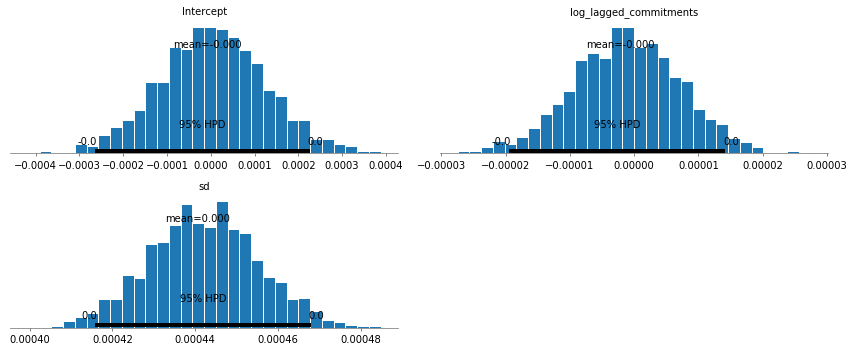

In [20]:
pm.plot_posterior(normal_trace)
plt.show()

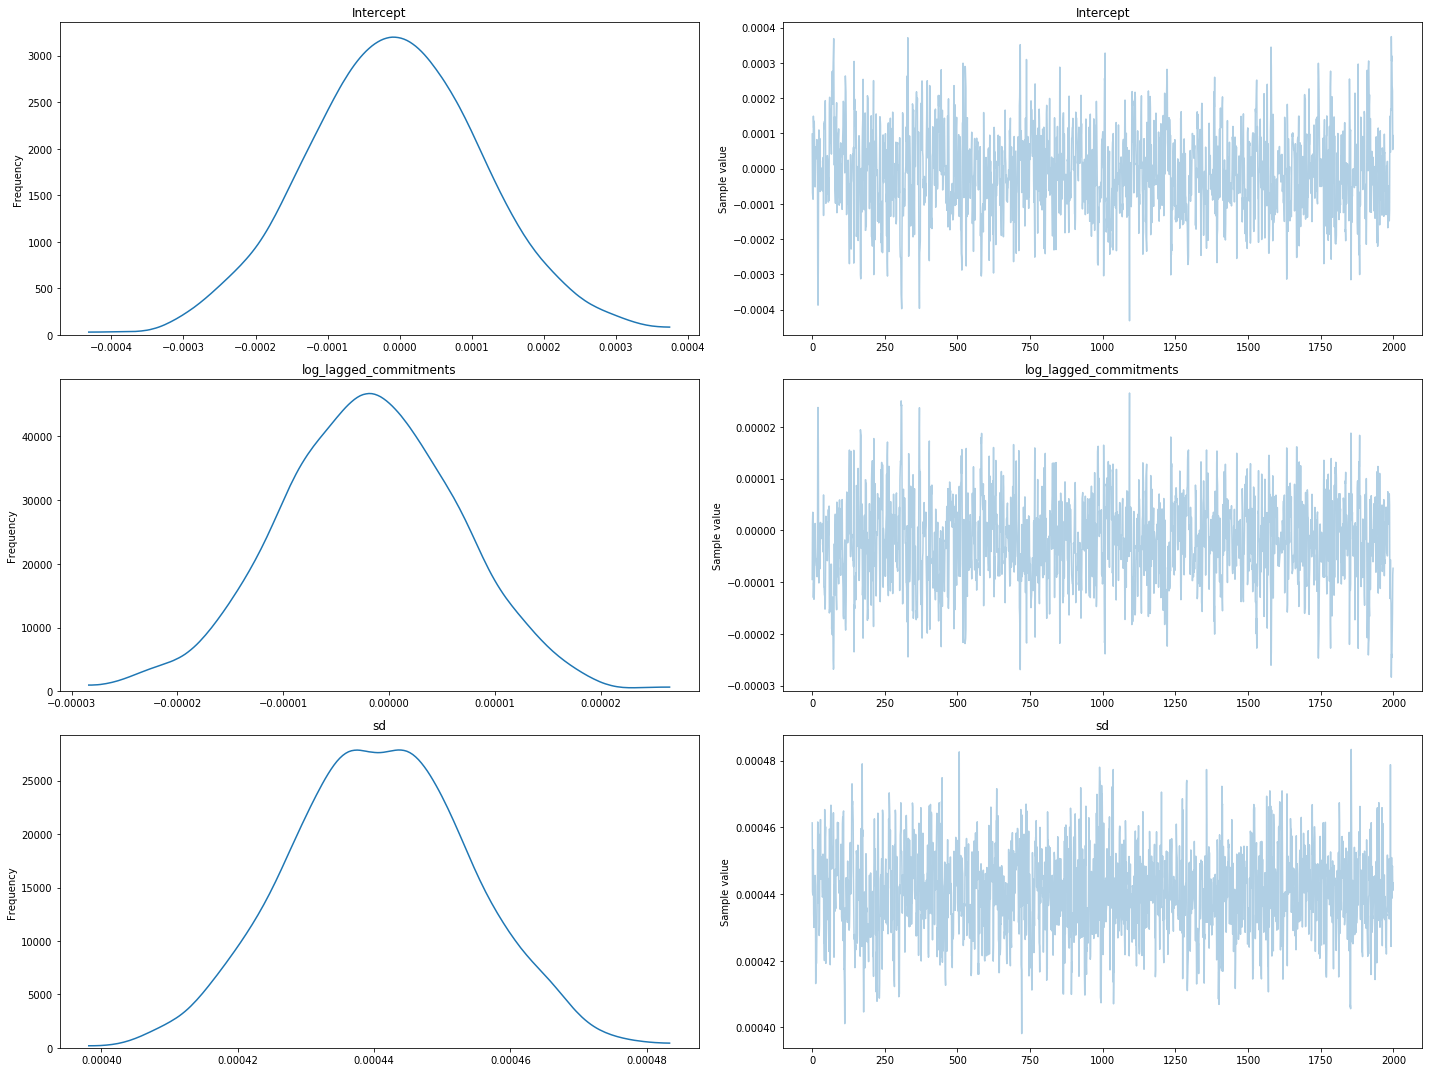

In [18]:
pm.traceplot(normal_trace, figsize = (20, 15))
plt.savefig('Graphs\\traceplot_full_data.png')
plt.show()